In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging, behavior, scan, model
from adamacs.ingest import session as isess
from adamacs.helpers import stack_helpers as sh
from adamacs.ingest import behavior as ibe
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dj.__version__

[2023-08-01 17:08:59,992][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-08-01 17:09:00,039][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.1'

### some functions used here (will be hidden later)

In [2]:
import bisect
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
import concurrent.futures
import cv2

def get_closest_timestamps(series, target_timestamp):
    # List to store the indices
    indices = []

    # For each timestamp in series1, find the closest timestamp in series2 and get its index
    for t1 in series:
        closest_index = closest_timestamp(target_timestamp, t1)
        indices.append(closest_index)
    return indices

# Function to find closest timestamp
def closest_timestamp(series, target_timestamp):
    index = bisect.bisect_left(series, target_timestamp)
    if index == 0:
        return 0
    if index == len(series):
        return len(series)-1
    before = series[index - 1]
    after = series[index]
    if after - target_timestamp < target_timestamp - before:
       return index
    else:
       return index-1


def resize_movie(movie, new_height, new_width):
    # Get the number of frames and color channels
    num_frames, _, _, num_channels = movie.shape
    
    # Initialize an empty array for the scaled movie
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)
    
    # Iterate through each frame
    for i in tqdm(range(num_frames), desc="Resizing frames"):
        # Resize the frame and store it in the new array
        scaled_movie[i] =  cv2.resize(movie[i], (new_width, new_height), interpolation = cv2.INTER_AREA)
    
    # Return the scaled movie
    return scaled_movie


def resize_frame(frame, new_height, new_width):
    return cv2.resize(frame, (new_width, new_height), interpolation = cv2.INTER_AREA)

def resize_movie_mt(movie, new_height, new_width):
    num_frames, _, _, num_channels = movie.shape
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, resized_frame in tqdm(enumerate(executor.map(resize_frame, movie, [new_height]*num_frames, [new_width]*num_frames)), total=num_frames, desc="Resizing frames"):
            scaled_movie[i] = resized_frame

    return scaled_movie


import numpy as np
from skimage.transform import resize
import concurrent.futures


# Figure Style settings for notebook.

import matplotlib as mpl

plot_params = {
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'font.family': 'sans-serif',
    # 'font.sans-serif': 'Helvetica Neue',
    'font.size': 16,
    'lines.color': 'black',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.edgecolor': 'black',  
    # 'legend.frameon': False,
    'figure.subplot.wspace': .5,
    'figure.subplot.hspace': .5,
    # 'figure.figsize': (18, 13),
    'ytick.major.left': True,
    'xtick.major.bottom': True
}

img_params = {
    'axes.facecolor': 'black',
    'figure.facecolor': 'black',
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
    'xtick.major.bottom': False
}


# Recordings and example analysis for BonnBrain - JISOOJ

In [3]:
# Jisoo - example scans

# mini2p
# sessi = sess9FJBPNSP


# bench2p
# sessi = sess9FH37WBZ


# Bench2p figures and examples

In [4]:
# first define a key to be used across multiple tables

scansi = "scan9FH37WBZ"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')
sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0] # check setup type (not needed)
print(aux_setup_typestr)

bench2p


### Get and show overview images from suite2p registration

In [5]:
ref_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('ref_image')
average_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('average_image')
correlation_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('correlation_image')
max_proj_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('max_proj_image')

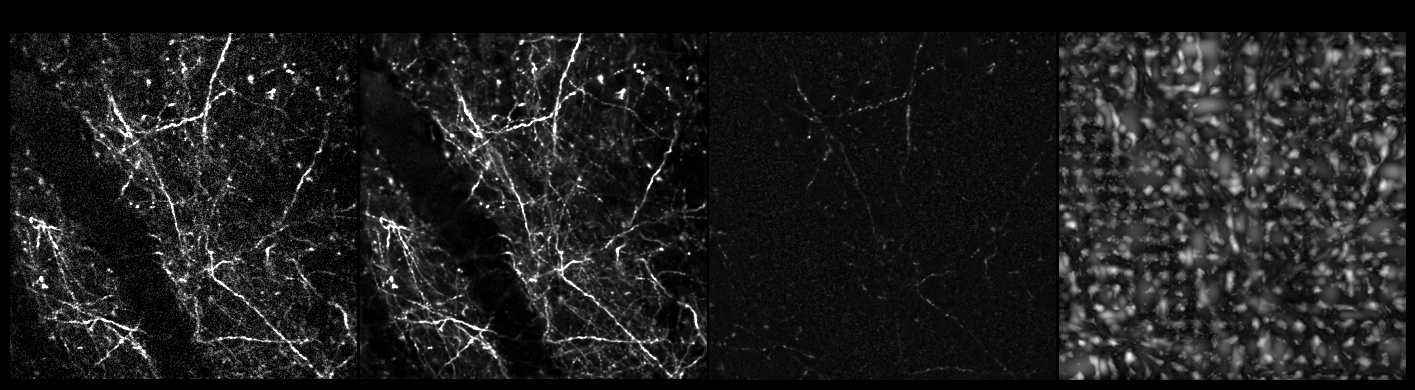

In [6]:
# get some scaling values from pixel distribution
scalemin = 2
scalemax = 99

cmin = np.percentile(average_image,scalemin)  
cmax = np.percentile(average_image,scalemax)

# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

# Make figure with all templates
plt.subplot(1, 4, 1)
plt.imshow(ref_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Registered Image, Mean Projection");

plt.subplot(1, 4, 3)
plt.imshow(max_proj_image, cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 4)
plt.imshow(correlation_image, cmap='gray')
plt.title("Registered Image, Correlation Map")
plt.show(block=False)
# plt.savefig

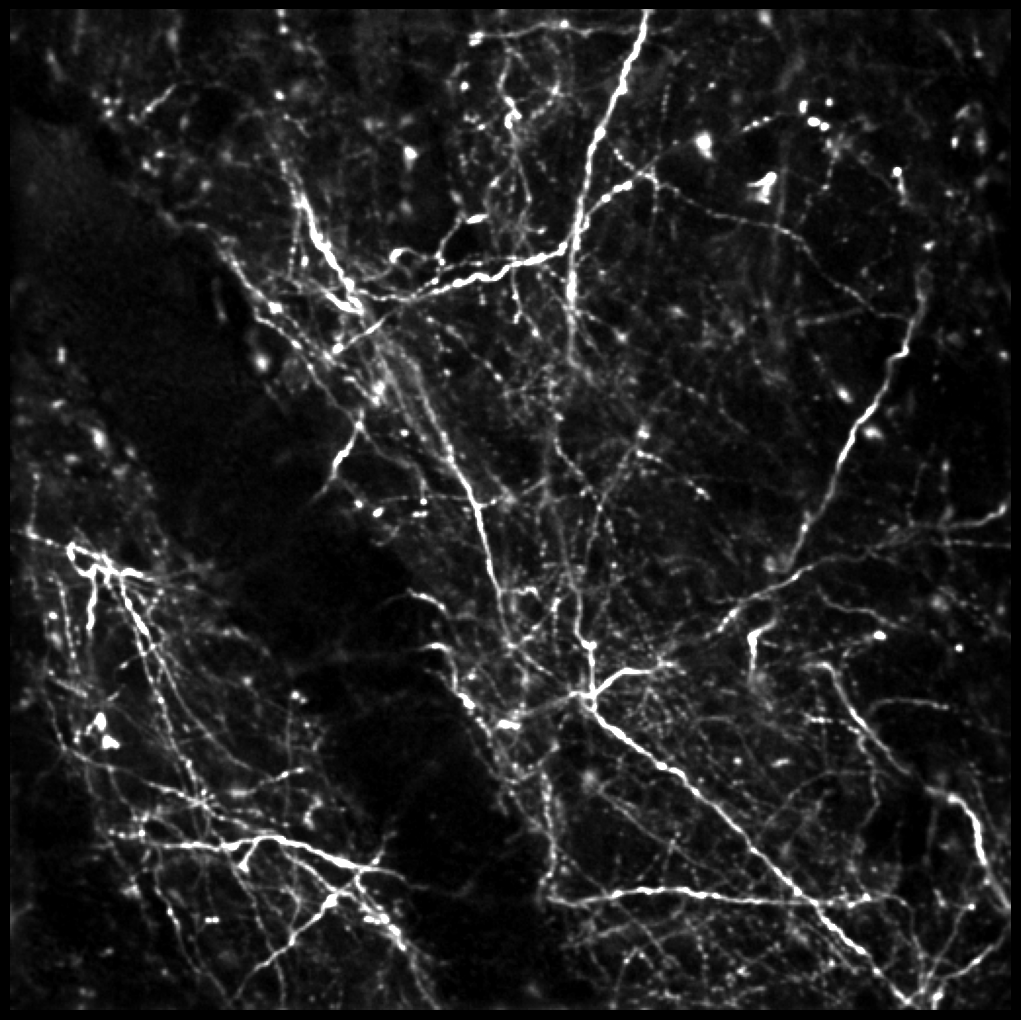

In [7]:
# just mean image
scalemin = 2
scalemax = 99

cmin = np.percentile(average_image,scalemin)  
cmax = np.percentile(average_image,scalemax)


# plt.subplot(1, 4, 1)
plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.show()


### Plot treadmill data

In [8]:
# extract scan treadmill data from database using the scan_key from above
treadmill = (behavior.TreadmillRecording.Channel() & scan_key).fetch("data")[0]
auxtime = (behavior.TreadmillRecording.Channel() & scan_key).fetch("time")[0]

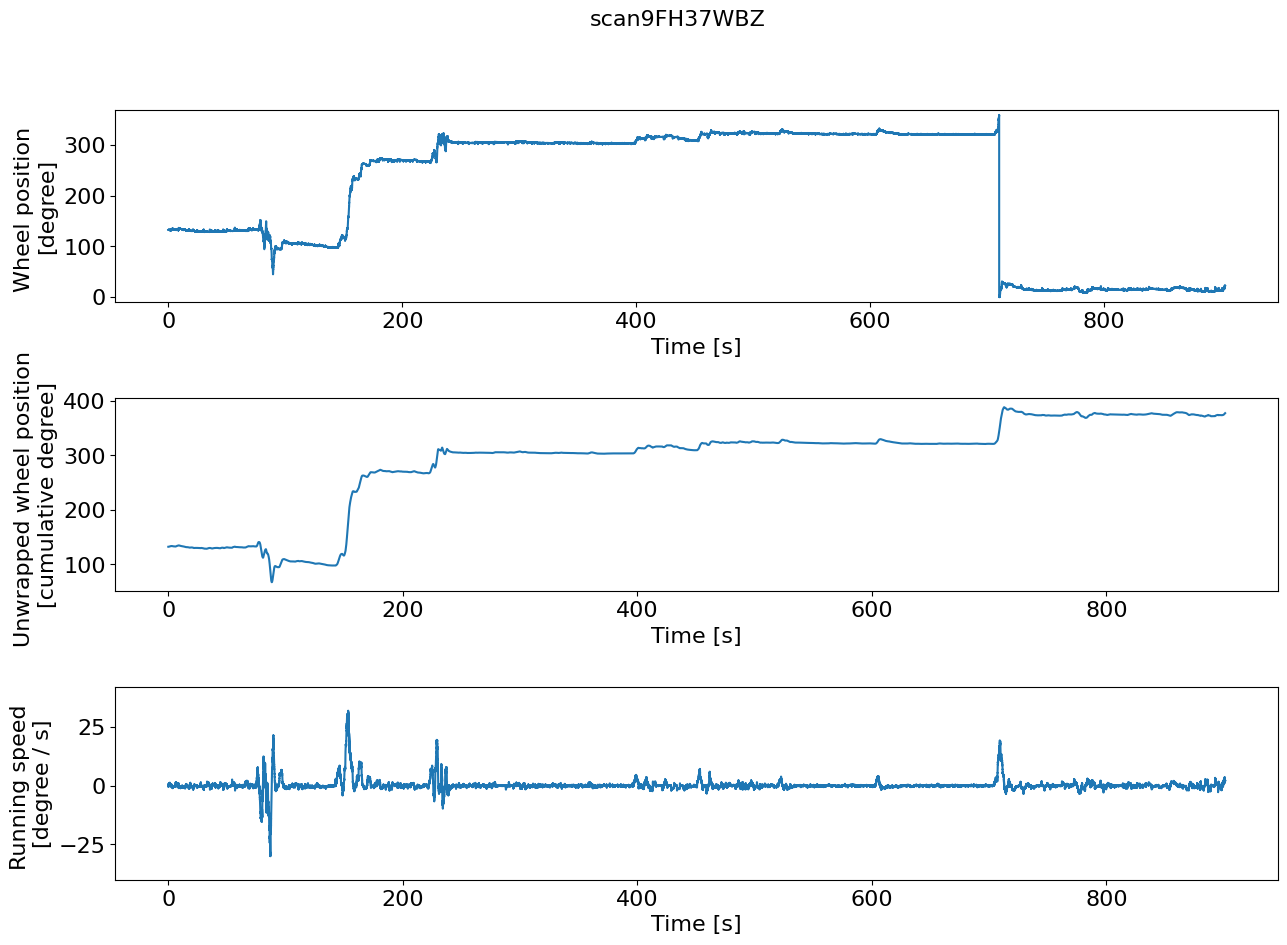

In [18]:
# smoothing window size (ms)
window = 5000

# convert voltage to degree
treadmillnorm = (treadmill-np.min(treadmill)) / np.max(treadmill) * 360

# compute running speed (see function above)
angular_velocity_smoothed, unwrapped_angle_smoothed = ibe.compute_angular_velocity(auxtime, treadmillnorm, window)

# get some values to scale running speed plot 
scalemin = 0
scalemax = 100
offset = 10
ymin = np.percentile(angular_velocity_smoothed,scalemin)  - offset
ymax = np.percentile(angular_velocity_smoothed,scalemax)  + offset

# load plot styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
# plt.rcParams['agg.path.chunksize'] = 10000  # Add this line if it does not rende

# Plotting the time series
axes[0].plot(auxtime, treadmillnorm)
axes[0].set_ylim([-10, 370])
axes[0].set_ylabel("Wheel position \n[degree]")
axes[0].set_xlabel("Time [s]")

axes[1].plot(auxtime[:-window+1],unwrapped_angle_smoothed )
# axes[1].set_ylim([-10000, 10000])
axes[1].set_ylabel("Unwrapped wheel position \n[cumulative degree]")
axes[1].set_xlabel("Time [s]")

axes[2].plot(auxtime[:-window],angular_velocity_smoothed)
axes[2].set_ylim([ymin, ymax])
axes[2].set_ylabel("Running speed \n[degree / s]")
axes[2].set_xlabel("Time [s]")

fig.suptitle(scan_key["scan_id"], fontsize=16)

plt.show() 

### Get the fluorescence traces of this recording

In [31]:
# get mask positions of masks that are classified as cells and that are larger than a certain pixel size
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & scan_key
    & "mask_npix > 1"
).fetch("mask_xpix", "mask_ypix")

Using this query, we've fetched the coordinates of segmented masks. We can overlay these
masks onto our average image.

In [32]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

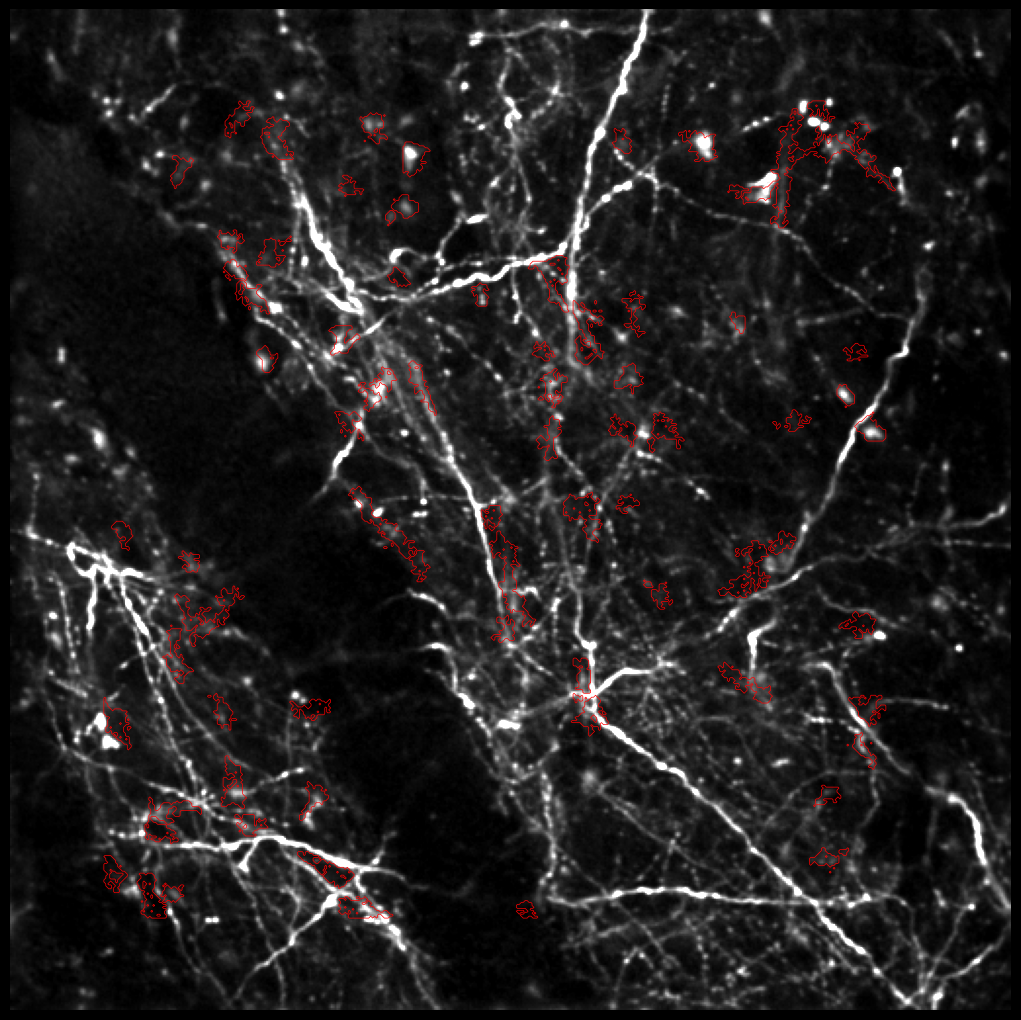

In [33]:
# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.contour(mask_image, colors="red", linewidths=0.5)
plt.show()

One more example using queries - plot fluorescence and deconvolved activity
traces:

Here we fetch the primary key attributes of the entry with `curation_id=0` for the
current session in the `imaging.Curation` table. 

Then, we fetch all cells that fit the
restriction criteria from `imaging.Segmentation.Mask` and
`imaging.MaskClassification.MaskType` as a `projection`. 

We then use this projection as
a restriction to fetch and plot fluorescence and deconvolved activity traces from the
`imaging.Fluorescence.Trace` and `imaging.Activity.Trace` tables, respectively.

In [36]:
curation_key = (imaging.Curation & scan_key & "curation_id=1").fetch1("KEY")
query_cells = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & curation_key
    & "mask_center_z=0"
    & "mask_npix > 1"
).proj()

query_cells

session_id,scan_id,paramset_idx,curation_id,mask,mask_classification_method
sess9FH37WBZ,scan9FH37WBZ,0,1,0,suite2p_default_classifier
sess9FH37WBZ,scan9FH37WBZ,0,1,1,suite2p_default_classifier
sess9FH37WBZ,scan9FH37WBZ,0,1,2,suite2p_default_classifier
sess9FH37WBZ,scan9FH37WBZ,0,1,3,suite2p_default_classifier
sess9FH37WBZ,scan9FH37WBZ,0,1,4,suite2p_default_classifier
sess9FH37WBZ,scan9FH37WBZ,0,1,5,suite2p_default_classifier
sess9FH37WBZ,scan9FH37WBZ,0,1,6,suite2p_default_classifier
sess9FH37WBZ,scan9FH37WBZ,0,1,8,suite2p_default_classifier
sess9FH37WBZ,scan9FH37WBZ,0,1,9,suite2p_default_classifier
sess9FH37WBZ,scan9FH37WBZ,0,1,11,suite2p_default_classifier


In [37]:
fluorescence_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "fluorescence", order_by="mask"
)

activity_traces = (imaging.Activity.Trace & query_cells).fetch(
    "activity_trace", order_by="mask"
)

sampling_rate = (scan.ScanInfo & curation_key).fetch1("fps")

In [38]:
fluos = np.vstack(fluorescence_traces)


In [39]:
from rastermap import Rastermap
from scipy import stats 
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d

nan_mask = np.isnan(fluos).any(axis=1)
S = fluos[~nan_mask]
S = zscore(S, axis=1)

model = Rastermap(n_clusters=100, # number of clusters to compute
                  n_PCs=128, # number of PCs to use
                  locality=0.75, # locality in sorting to find sequences (this is a value from 0-1)
                  time_lag_window=5, # use future timepoints to compute correlation
                  grid_upsample=10, # default value, 10 is good for large recordings
                ).fit(S)
y = model.embedding # neurons x 1
isort = model.isort


# sort by embedding and smooth over neurons
# Sfilt = running_average(S[isort], 0)
Sfilt = gaussian_filter1d(S[isort], np.minimum(8,np.maximum(1,int(S.shape[0]*0.001))),axis=0)
# Sfilt = np.vstack(fluorescence_traces)
Sfilt = stats.zscore(Sfilt, axis=1)


/home/tobiasr/miniconda3/envs/dj_pure/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.01sec
sorting activity: 88 valid samples by 27000 timepoints
n_PCs = 88 computed, 1.20sec
39 clusters computed, time 1.31sec


/home/tobiasr/miniconda3/envs/dj_pure/lib/python3.8/site-packages/rastermap/cluster.py:139: UserWarning: found fewer than half the n_clusters that the user specified, rerunning with random initialization
  warnings.warn(
/home/tobiasr/miniconda3/envs/dj_pure/lib/python3.8/site-packages/rastermap/cluster.py:149: UserWarning: found fewer clusters than user specified, try reducing n_clusters and/or reduce n_splits and/or increase n_PCs
  warnings.warn(


clusters sorted, time 1.69sec
clusters upsampled, time 1.73sec
rastermap complete, time 1.74sec


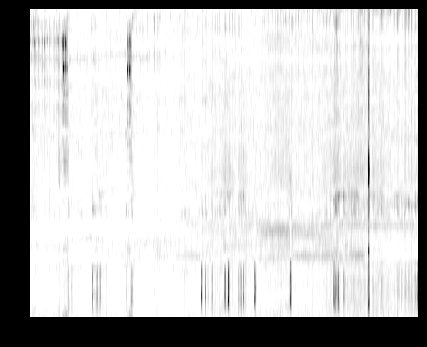

In [42]:
plt.figure(figsize=(5,4))
plt.imshow(Sfilt, vmin = -0.1, vmax=4, aspect='auto', cmap='gray_r')
plt.xlabel('time points')
plt.ylabel('sorted neurons')
plt.show()

#### Synchronization!

In [ ]:
# and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='bench2p_frames'" &  scan_key ).fetch('event_start_time')
aligned_wheel_indices = get_closest_timestamps(twoptimestamps,auxtime[:-window]) #smoothing windwo from above

# use this to index into the wheelspeed
angular_velocity_smoothed_2pref = angular_velocity_smoothed[aligned_wheel_indices]

# both arrays have same shape now - now 2pdata and wheel speed can be plotted together on the 2ptimestamps
print(np.shape(twoptimestamps))
print(np.shape(angular_velocity_smoothed_2pref))


In [ ]:
angular_velocity_smoothed_2pref

In [ ]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_start_time')

# Then return camera start timestamps within the recording gate only 
cameratimestamps = (event.Event()  &  "event_type='aux_cam'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scan_key).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scan_key ).fetch('event_start_time')

twoptimestamps =  twoptimestamps[:np.shape(blinkvideodata)[0]] # truncating 2p timestamps to number of 2p videoframes

#  Zero camera timestamps on first 2p timestamp. (not necessary)
# cameratimestamps = cameratimestamps - twoptimestamps[0]
# twoptimestamps = twoptimestamps - twoptimestamps[0]

In [ ]:
event.Event() & scanquery  &  "event_type='aux_cam'"

In [ ]:
# align the two recordings by finding the indices of the closest camera timestamp that fits the 2p frame timestamps by sorted list insertion ("bisect"). Be aware: camera frames can be double.
aligned_cameraframes = get_closest_timestamps(twoptimestamps,cameratimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(aligned_cameraframes))


# Delete individual scans, sessions or mice

In [ ]:
populate_settings = {'display_progress': True, 'suppress_errors': True, 'processes': 1}

In [ ]:
imaging.Processing()

In [ ]:
query = session.Session() * scan.Scan() & f'session_id = "{sessi}"'
scans_to_process = query.fetch("scan_id")
for j, scansi in enumerate(scans_to_process):
    imaging.Curation().create1_from_processing_task({'session_id': sessi, 'scan_id': scansi, "paramset_idx": selected_s2pparms_index[i], "manual_curation": session_checkboxes[i][1].value})


In [ ]:
imaging.Curation().delete()

In [ ]:
model.PoseEstimation.BodyPartPosition()

In [ ]:
imaging.Curation()


In [ ]:
behavior.HarpRecording.Channel()

In [ ]:
model.

In [ ]:
scan.ScanInfo.populate(**populate_settings) 

In [ ]:
# (session.Session & "session_id = 'sess9FI3KWP3'").delete()
# (subject.Subject & "subject = 'ROS-1571'").delete()
subject.Subject.delete()
session.Session.delete()
imaging.Processing.delete()
imaging.Curation.delete()
event.Event.delete()
event.Behavior.delete()
scan.Scan.delete()
event.Behavior.delete()

# Manual ingest of specifc recordings

In [ ]:
# scansi = "scan9FJ4IJOQ"
scansi = "scan9FJBPNSP"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0]


session.SessionUser() * subject.User() & scan_key

In [ ]:
query = session.Session() * scan.Scan() & f'session_id = "{sessi}"'
scans_to_process = query.fetch("scan_id")
for j, scansi in enumerate(scans_to_process):
    imaging.Curation().create1_from_processing_task({'session_id': sessi, 'scan_id': scansi, "paramset_idx": 0, "manual_curation": False})


In [ ]:
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0]  
aux_setup_typestr


In [ ]:
ibe.ingest_aux(sessi,scansi,verbose=True, aux_setup_type=aux_setup_typestr)

In [ ]:
event.Event() & scan_key

In [ ]:
ibe.get_and_ingest_trial_times(scansi, aux_setup_typestr) 

In [ ]:
# (event.BehaviorRecording() & scan_key).delete()
(event.BehaviorRecording() & scan_key)

In [ ]:
scan.ScanPath &  scan_key


In [ ]:
behavior.HarpRecording.populate()

In [ ]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]  



ibe.get_and_ingest_trial_times(scansi, aux_setup_typestr) 

behavior.TreadmillRecording.populate()
behavior.HarpRecording.populate()

key = {'session_id': scan_key["session_id"],
                                'recording_id': scan_key["scan_id"], 
                                'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
                                }
                                
imaging.Processing.populate(**populate_settings)
imaging.Curation().create1_from_processing_task({'session_id': sessi, 'scan_id': scansi, "paramset_idx": selected_s2pparms_index[i], "manual_curation": session_checkboxes[i][1].value})


In [ ]:
imaging.MotionCorrection.populate(**populate_settings)

imaging.Segmentation.populate(**populate_settings)

imaging.MaskClassification.populate(**populate_settings)

imaging.Fluorescence.populate(**populate_settings)

imaging.Activity.populate(**populate_settings)